# Setup and Config

In [54]:
#import packages
from sqlalchemy import create_engine
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Config MySQL credential in localhost
user ='root'
password ='root'
host ='localhost'
port = 3306
database = 'grocery_sales'

# Format connection string SQLAlchemy
connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'

# Create engine connection
engine = create_engine(connection_string)


# Data Preparation

In [3]:
# Query for Daily Data
daily_data = "SELECT * FROM ct_forecast_business_main_metrics_daily"

# Formatting query result to DataFrame
df_daily = pd.read_sql(daily_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_daily.head())

     date_key  total_order  total_revenue  total_discount
0  2018-01-01        51856   2,640,588.96        1,504.70
1  2018-01-02        52059   2,639,210.97        1,572.00
2  2018-01-03        51306   2,610,001.02        1,535.00
3  2018-01-04        51527   2,617,471.57        1,530.90
4  2018-01-05        52101   2,643,557.21        1,540.20


In [103]:
# Query for Weekly Data
weekly_data = "SELECT * FROM ct_forecast_business_main_metrics_weekly"

# Formatting query result to DataFrame
df_weekly = pd.read_sql(weekly_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_weekly.head())

   week_key  total_order  total_revenue  total_discount
0  2018-W01       362796  18,440,597.70       10,794.70
1  2018-W02       361996  18,400,902.74       10,855.70
2  2018-W03       363233  18,469,983.84       10,909.80
3  2018-W04       363683  18,469,668.27       10,930.00
4  2018-W05       362496  18,447,214.80       10,812.70


In [4]:
# Query for Monhtly Data
monthly_data = "SELECT * FROM ct_forecast_business_main_metrics_monthly"

# Formatting query result to DataFrame
df_monthly = pd.read_sql(monthly_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_monthly.head())

  month_key  total_order  total_revenue  total_discount
0   2018-01      1607050  81,676,812.77       48,151.30
1   2018-02      1451366  73,711,240.93       43,390.80
2   2018-03      1609190  81,830,870.36       48,299.20
3   2018-04      1556091  79,098,404.98       46,655.60


# Forecasting Process

## Forecasting - Daily

### Forecast Order

In [5]:
# rename column to follow Prophet prerequisite
df_daily_prophet_order = df_daily.rename(columns = {'date_key':'ds','total_order':'y'} )

print(df_daily_prophet_order.head())


           ds      y  total_revenue  total_discount
0  2018-01-01  51856   2,640,588.96        1,504.70
1  2018-01-02  52059   2,639,210.97        1,572.00
2  2018-01-03  51306   2,610,001.02        1,535.00
3  2018-01-04  51527   2,617,471.57        1,530.90
4  2018-01-05  52101   2,643,557.21        1,540.20


10:57:00 - cmdstanpy - INFO - Chain [1] start processing
10:57:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_13124\2080645814.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_daily_order['total_discount'].fillna(avg_discount, inplace=True)


            ds      yhat  yhat_lower  yhat_upper
360 2018-12-27 51,826.04   51,491.76   52,149.28
361 2018-12-28 51,914.27   51,609.78   52,245.95
362 2018-12-29 51,837.95   51,512.33   52,148.09
363 2018-12-30 51,850.74   51,531.55   52,204.02
364 2018-12-31 51,796.05   51,503.21   52,124.06


C:\Users\yusuf\AppData\Local\Temp\ipykernel_13124\2080645814.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


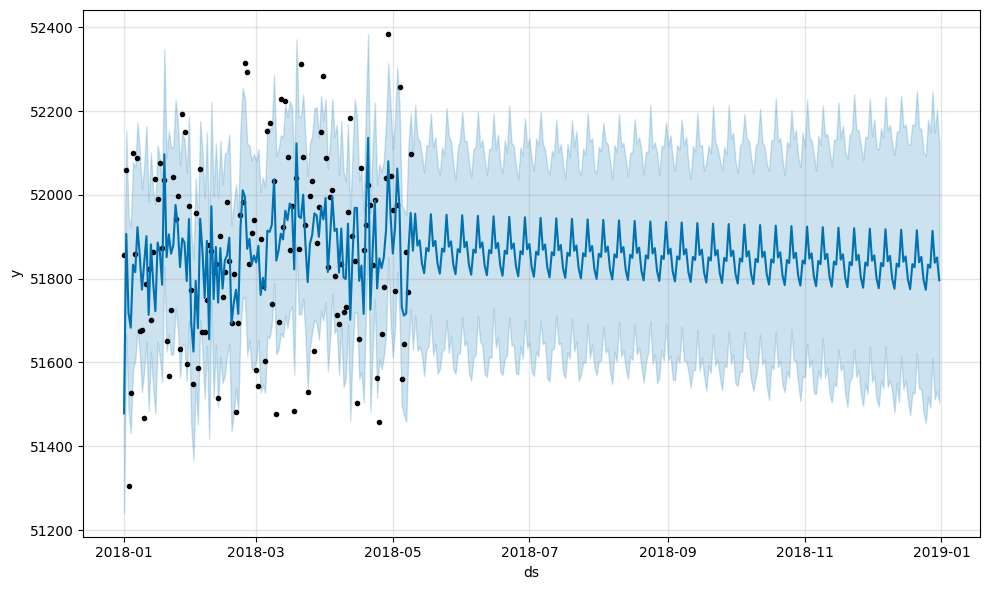

In [10]:
# create Prophet's Model
m = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_daily_prophet_order['ds'].max())
end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_days = (end_of_year - last_date).days

# Add variable discount as additional regressor
m.add_regressor('total_discount')

# Fit model to the data
m.fit(df_daily_prophet_order)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_daily_order = m.make_future_dataframe(periods= forecast_days)

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_daily_prophet_order['ds'] = pd.to_datetime(df_daily_prophet_order['ds'])
future_daily_order['ds'] = pd.to_datetime(future['ds'])

future_daily_order = future_daily_order.merge(
    df_daily_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_daily_prophet_order['total_discount'].mean()
future_daily_order['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_daily_order = m.predict(future_daily_order)

# Show the prediction result for few last rows
print(future_daily_order[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m.plot(future_daily_order)
fig.show()



### Evaluate Forecast Order Model Result

In [11]:
# Parse data to have same data type
df_daily_prophet_order['ds'] = pd.to_datetime(df_daily_prophet_order['ds'])
future_daily_order['ds'] = pd.to_datetime(future_daily_order['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_daily = df_daily_prophet_order.merge(future_daily_order[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_daily_eval = df_merged_daily[df_merged_daily['yhat'].notnull()]

# Calculate MAE
mae = mean_absolute_error(df_daily_eval['y'], df_daily_eval['yhat'])
print(f'MAE: {mae:.2f}')

# Calculate MAPE
mape = np.mean(np.abs((df_daily_eval['y'] - df_daily_eval['yhat']) / df_daily_eval['y'])) * 100
print(f'MAPE: {mape:.2f}%')


MAE: 153.51
MAPE: 0.30%


### Forecast Revenue

In [64]:
# Data Load and parse
df_daily_prophet_order['ds'] = pd.to_datetime(df_daily_prophet_order['ds'])

12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_13124\1099192643.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_daily_revenue['total_discount'].fillna(avg_discount, inplace=True)
C:\Users\yusuf\AppData\Local\Temp\ipykernel_13124\1099192643.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


            ds      yhat  yhat_lower  yhat_upper
360 2018-12-27 51,826.04   51,515.13   52,148.29
361 2018-12-28 51,914.27   51,613.34   52,252.97
362 2018-12-29 51,837.95   51,535.91   52,182.83
363 2018-12-30 51,850.74   51,527.81   52,196.61
364 2018-12-31 51,796.05   51,471.55   52,135.14


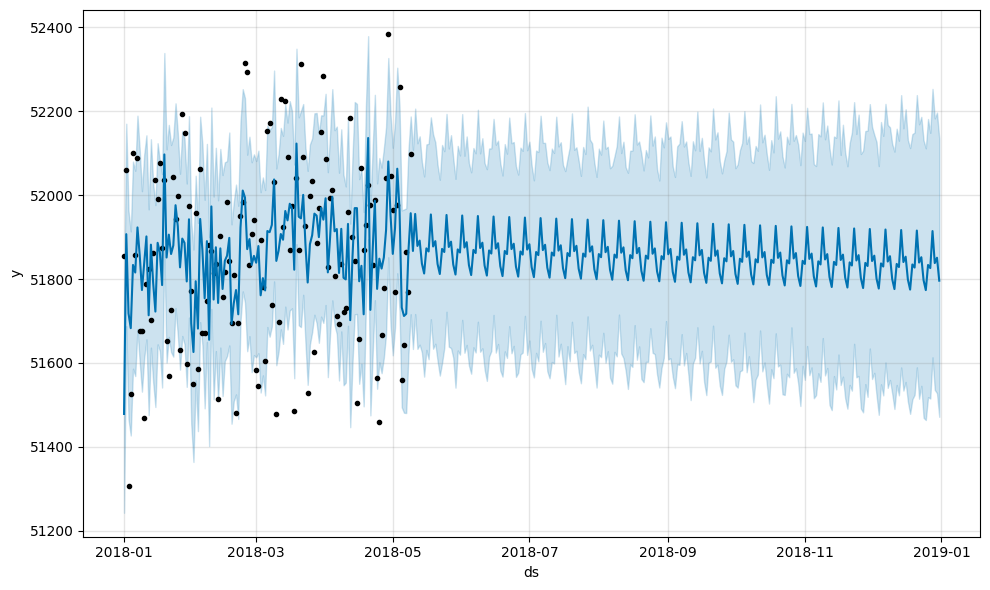

In [65]:
# Inisiasi model Prophet dengan express intent lewat nama variabel yg jelas
m_daily_revenue = Prophet()

# Hitung periode ramalan sampai akhir tahun
last_date = df_daily_prophet_order['ds'].max()
end_of_year = pd.Timestamp(year=last_date.year, month=12, day=31)
forecast_days = (end_of_year - last_date).days

# Tambahkan regressor tambahan: diskon total
m_daily_revenue.add_regressor('total_discount')

# Fit model
m_daily_revenue.fit(df_daily_prophet_order)

# Buat dataframe untuk periode forecast sampai akhir tahun
future_daily_revenue = m_daily_revenue.make_future_dataframe(periods=forecast_days)

# Merge data diskon historis ke dataframe future
future_daily_revenue = future_daily_revenue.merge(
    df_daily_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# Isi nilai diskon di masa depan dengan rata-rata diskon historis
avg_discount = df_daily_prophet_order['total_discount'].mean()
future_daily_revenue['total_discount'].fillna(avg_discount, inplace=True)

# Prediksi revenue
forecast_daily_revenue = m_daily_revenue.predict(future_daily_revenue)

# Tampilkan hasil prediksi periode akhir
print(forecast_daily_revenue[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualisasi prediksi
fig = m_daily_revenue.plot(forecast_daily_revenue)
fig.show()


### Evaluate Forecast Revenue Model Result

### Combined Forecast Order and Revenue

In [23]:
print(forecast_for_revenue.tail())

            ds  forecast_revenue  forecast_revenue_lower  \
360 2018-12-27               inf                     inf   
361 2018-12-28               inf                     inf   
362 2018-12-29               inf                     inf   
363 2018-12-30               inf                     inf   
364 2018-12-31               inf                     inf   

     forecast_revenue_upper  
360                     inf  
361                     inf  
362                     inf  
363                     inf  
364                     inf  


forecast_order_result = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
print(forecast_order_result.tail())

In [66]:
# Merge forecast dengan data order aktual berdasarkan tanggal 'ds'
df_order_forecast = pd.merge(
    df_daily_prophet_order,
    forecast_daily_revenue[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)

print(df_order_forecast.head())


          ds      y  total_revenue  total_discount      yhat  yhat_lower  \
0 2018-01-01  51856   2,640,588.96        1,504.70 51,478.48   51,242.97   
1 2018-01-02  52059   2,639,210.97        1,572.00 51,906.91   51,687.68   
2 2018-01-03  51306   2,610,001.02        1,535.00 51,718.02   51,465.71   
3 2018-01-04  51527   2,617,471.57        1,530.90 51,682.92   51,427.17   
4 2018-01-05  52101   2,643,557.21        1,540.20 51,833.51   51,586.24   

   yhat_upper  
0   51,729.03  
1   52,170.06  
2   51,962.36  
3   51,913.51  
4   52,079.84  


### Push Data to Database